inplace False
state:379,value:40.0,reward:40.0,v_prime:0.0,state_prime:380
state:380,value:50.0,reward:50.0,v_prime:0.0,state_prime:380
state:381,value:60.0,reward:60.0,v_prime:0.0,state_prime:380
state:379,value:85.0,reward:40.0,v_prime:50.0,state_prime:380
state:380,value:95.0,reward:50.0,v_prime:50.0,state_prime:380
state:381,value:105.0,reward:60.0,v_prime:50.0,state_prime:380
state:379,value:125.5,reward:40.0,v_prime:95.0,state_prime:380
state:380,value:135.5,reward:50.0,v_prime:95.0,state_prime:380
state:381,value:145.5,reward:60.0,v_prime:95.0,state_prime:380
state:379,value:161.95,reward:40.0,v_prime:135.5,state_prime:380
state:380,value:171.95,reward:50.0,v_prime:135.5,state_prime:380
state:381,value:181.95,reward:60.0,v_prime:135.5,state_prime:380
state:379,value:194.755,reward:40.0,v_prime:171.95,state_prime:380
state:380,value:204.755,reward:50.0,v_prime:171.95,state_prime:380
state:381,value:214.755,reward:60.0,v_prime:171.95,state_prime:380
state:379,value:224.2795,reward

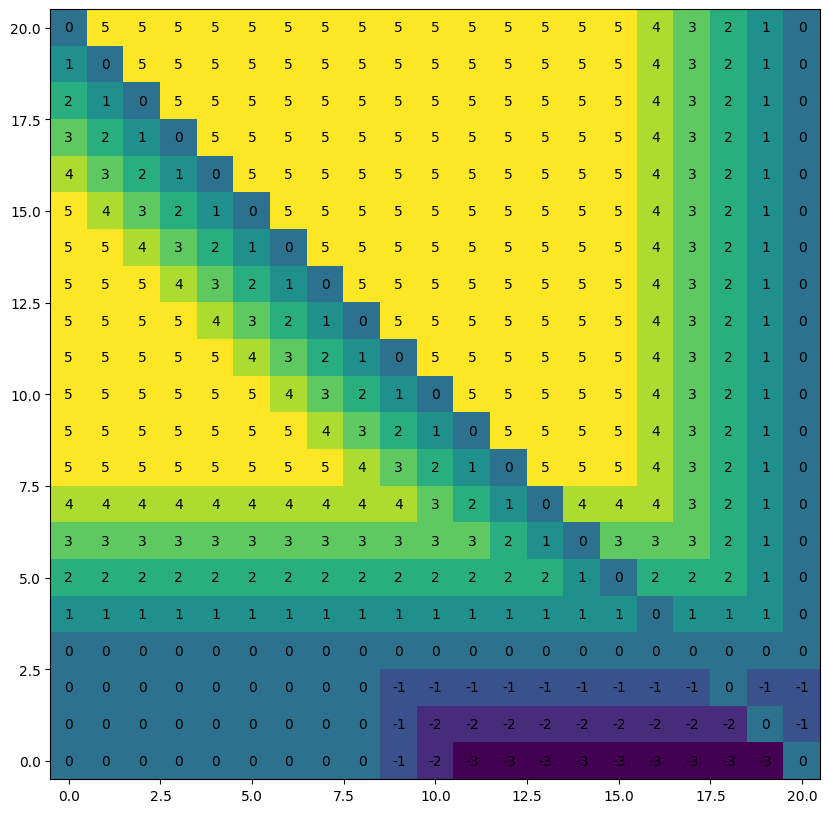

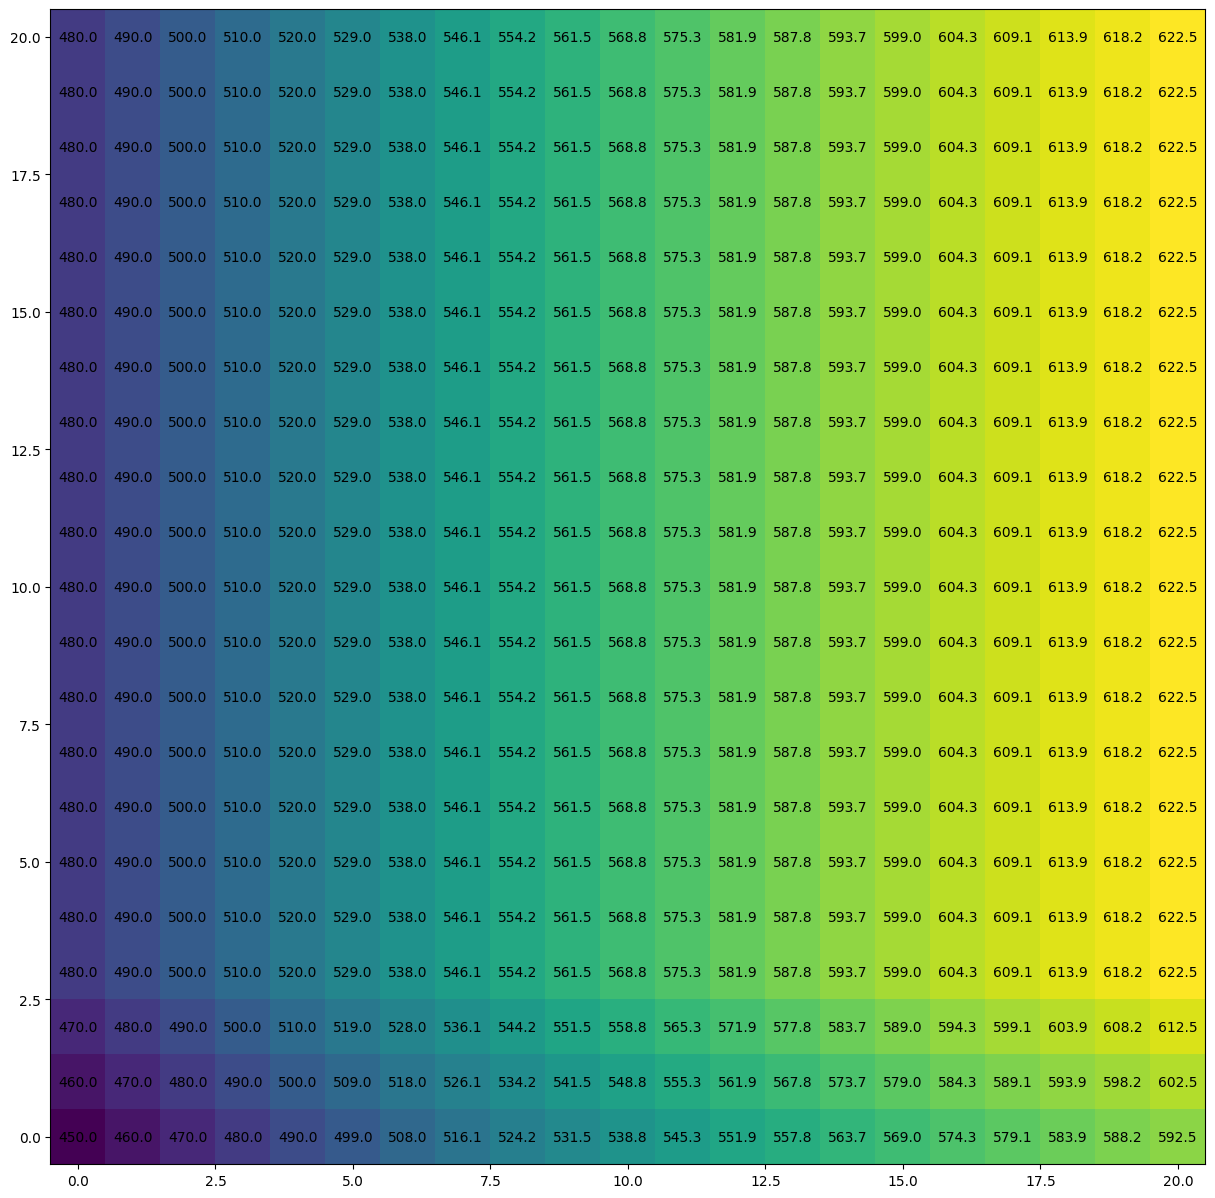

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import profile

max_num_cars = 20
grid_size = max_num_cars + 1 
num_states = grid_size * grid_size
invalid_state = num_states
e_rental_1 = 3
e_rental_2 = 4
e_return_1 = 3
e_return_2 = 2

max_moving = 5
num_actions = max_moving * 2 + 1

action_state_transition = np.zeros((num_states,num_actions,num_states),dtype=float)
action_reward = np.zeros((num_states,num_actions,num_states),dtype=float)


for y in range(grid_size):
    cars1 = y
    for x in range(grid_size):
        cars2 = x
        for action in range(num_actions):
            num_moving = action - 5
            new_cars1 = cars1 - num_moving 
            new_cars2 = cars2 + num_moving
            if new_cars1 < 0 or new_cars1 > max_num_cars or new_cars2 < 0 or new_cars2 > max_num_cars:
                action_state_transition[y * max_num_cars + x][action] = invalid_state
            else:
                moving_reward = abs(num_moving) * -2.0
                rental_reward_1 = min(new_cars1, e_rental_1) * 10
                rental_reward_2 = min(new_cars2, e_rental_2) * 10
                new_cars1 = max(new_cars1 - e_rental_1, 0)
                new_cars2 = max(new_cars2 - e_rental_2, 0)
                new_cars1 = min(new_cars1 + e_return_1, max_num_cars)
                new_cars2 = min(new_cars2 + e_return_2, max_num_cars)
                action_state_transition[y * grid_size + x][action] = new_cars1 * grid_size + new_cars2
                action_reward[y * grid_size + x][action] = moving_reward + rental_reward_1 + rental_reward_2

'''xxx = set()
for s in action_state_transition.reshape(-1):
    xxx.add(s)
print(len(xxx))'''

def evaluate_policy(policy, gamma, threshold = 1e-5, max_iteration = 0x100000, inplace = True):
    print("inplace",inplace)
    values = np.zeros(num_states)
    if not inplace:
        new_values = np.zeros(num_states)
    for iteration in range(max_iteration):
        delta = 0.0
        for state in range(num_states):
            v_new = 0.0
            valid_action_count = 0
            for index, action in enumerate(policy[state]):
                if action: 
                    state_prime = action_state_transition[state, index]
                    if state_prime != invalid_state:
                        v_prime = values[state_prime]
                        reward = action_reward[state,index]
                        v_new += (reward + gamma * v_prime)
                        valid_action_count += 1
                        if 379 <= state and state <= 381:
                            print(f"state:{state},value:{v_new},reward:{reward},v_prime:{v_prime},state_prime:{state_prime}")

            if valid_action_count != 0:
                v_new /= float(valid_action_count)
                delta = max(delta, abs(v_new - values[state]))
                if inplace:
                    values[state] = v_new
                else:
                    new_values[state] = v_new
        if not inplace:
            values, new_values = new_values, values #values = new_values.copy()#
        if delta <= threshold:
            break
    print("iteration:",iteration)
    return values

def improve_policy(values, gamma):
    policy = np.zeros((num_states, num_actions), dtype = bool)
    for s in range(num_states):
        new_values = np.full(num_actions, float('-inf'))
        for a in range(num_actions):
            s_prime = action_state_transition[s, a]
            if s_prime != invalid_state:
                reward = action_reward[s, a]
                v_prime = values[s_prime]
                new_values[a] = reward + gamma * v_prime
        
        max_value = np.max(new_values)
        if max_value == float('-inf'):
            policy[s] = np.zeros(num_actions, dtype = bool) 
        else:
            policy[s] = (max_value - new_values) <= 0.00001
    
    return policy

def policy_iteration(num_iteration):
    policy = np.zeros((num_states, num_actions), dtype = bool)
    policy[:,max_moving] = True
    for n in range(num_iteration):
        values = evaluate_policy(policy, 0.9, inplace = False)
        new_policy = improve_policy(values, 0.9)
        #policy_stable = (new_policy == policy).all()
        #if policy_stable:
        #    return policy
        policy = new_policy.copy()
    return policy,values

def show_policy(policy):
    policy = policy.argmax(axis=1).reshape(grid_size, grid_size)-5
    plt.rcParams['figure.figsize']=(10, 10)
    fig, ax  = plt.subplots()
    ax.imshow(policy, origin='lower')
    for y in range(grid_size):
        for x in range(grid_size):
            text = ax.text(x, y, f"{policy[y, x]}", ha="center", va="center", color=(0,0,0))

def show_values(values):
    plt.rcParams['figure.figsize']=(15, 15)
    fig, ax  = plt.subplots()
    values = values.reshape(grid_size, grid_size)
    ax.imshow(values, origin='lower')
    for y in range(grid_size):
        for x in range(grid_size):
            text = ax.text(x, y, f"{values[y, x]:.1f}", ha="center", va="center", color=(0,0,0))

def test(n):
    policy,values = policy_iteration(n)
    show_policy(policy)
    show_values(values)


#test(0)
test(1)


In [48]:
import math
def poisson(lam, num):
    return math.pow(lam, num) * math.exp(-lam) / math.factorial(num)
    #return math.pow(lam, num) * math.exp(-lam) / math.factorial(num)

def poisson2(lamb, k):
    return (lamb**k/math.factorial(k))*math.exp(-lamb)

def poisson3(lam, num):
    return np.power(lam,num) * np.exp(-lam) / np.factorial(num)


lam = np.array(4)
nums = np.arange(20,dtype=int)
#print(poisson3(lam,nums))
for n in range(40):
    print(n, poisson(4,n), poisson2(4,n))


0 0.01831563888873418 0.01831563888873418
1 0.07326255555493671 0.07326255555493671
2 0.14652511110987343 0.14652511110987343
3 0.19536681481316456 0.19536681481316456
4 0.19536681481316456 0.19536681481316456
5 0.15629345185053165 0.15629345185053165
6 0.1041956345670211 0.1041956345670211
7 0.059540362609726345 0.059540362609726345
8 0.029770181304863173 0.029770181304863173
9 0.013231191691050298 0.0132311916910503
10 0.0052924766764201195 0.0052924766764201195
11 0.0019245369732436798 0.00192453697324368
12 0.00064151232441456 0.00064151232441456
13 0.00019738840751217228 0.00019738840751217228
14 5.6396687860620656e-05 5.6396687860620656e-05
15 1.5039116762832175e-05 1.5039116762832175e-05
16 3.759779190708044e-06 3.759779190708044e-06
17 8.846539272254221e-07 8.84653927225422e-07
18 1.9658976160564933e-07 1.9658976160564933e-07
19 4.138731823276828e-08 4.138731823276828e-08
20 8.277463646553656e-09 8.277463646553656e-09
21 1.5766597422006965e-09 1.5766597422006965e-09
22 2.866654

In [ ]:
def poisson